In [87]:
%pip install ipywidgets


import pandas as pd
import numpy as np
import os
import seaborn as sns
from ipywidgets import interact, fixed
from dotenv import load_dotenv
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.animation import FFMpegWriter
pd.set_option('display.max_columns', 100)


import dateutil
from math import radians
from IPython.display import Video

import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


In [88]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=55,
                          highlight_first_down_line=False,
                          yards_to_go=10,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        #plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')
        
    if highlight_first_down_line:
        fl = hl + yards_to_go
        plt.plot([fl, fl], [0, 53.3], color='yellow')
        #plt.text(fl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')
    return fig, ax

In [89]:
def calculate_dx_dy_arrow(x, y, angle, speed, multiplier):
    if angle <= 90:
        angle = angle
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 90 and angle <= 180:
        angle = angle - 90
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = -np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 180 and angle <= 270:
        angle = angle - 180
        dx = -(np.sin(radians(angle)) * multiplier * speed)
        dy = -(np.cos(radians(angle)) * multiplier * speed)
        return dx, dy
    if angle > 270 and angle <= 360:
        angle = 360 - angle
        dx = -np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    
        
def animate_player_movement(weekNumber, playId, gameId):
    weekData = pd.read_csv('input/nfl-big-data-bowl-2021/week' + str(weekNumber) + '.csv')
    playData = pd.read_csv('input/nfl-big-data-bowl-2021/plays.csv')
    
    playHome = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "home"')
    playAway = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "away"')
    playFootball = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "football"')
    
    playHome['time'] = playHome['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playAway['time'] = playAway['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playFootball['time'] = playFootball['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    
    maxTime = int(playAway['time'].unique().max())
    minTime = int(playAway['time'].unique().min())
    
    yardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardlineNumber'].item()
    yardsToGo = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardsToGo'].item()
    absoluteYardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['absoluteYardlineNumber'].item() - 10
    playDir = playHome.sample(1)['playDirection'].item()
    
    if (absoluteYardlineNumber > 50):
        yardlineNumber = 100 - yardlineNumber
    if (absoluteYardlineNumber <= 50):
        yardlineNumber = yardlineNumber
        
    if (playDir == 'left'):
        yardsToGo = -yardsToGo
    else:
        yardsToGo = yardsToGo
    
    fig, ax = create_football_field(highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo)
    playDesc = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['playDescription'].item()
    plt.title(f'Game # {gameId} Play # {playId} \n {playDesc}')
    
    def update_animation(time):
        patch = []
        
        homeX = playHome.query('time == ' + str(time))['x']
        homeY = playHome.query('time == ' + str(time))['y']
        homeNum = playHome.query('time == ' + str(time))['jerseyNumber']
        homeOrient = playHome.query('time == ' + str(time))['o']
        homeDir = playHome.query('time == ' + str(time))['dir']
        homeSpeed = playHome.query('time == ' + str(time))['s']
        patch.extend(plt.plot(homeX, homeY, 'o',c='gold', ms=20, mec='white'))
        
        # Home players' jersey number 
        for x, y, num in zip(homeX, homeY, homeNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='black', size='medium'))
            
        # Home players' orientation
        for x, y, orient in zip(homeX, homeY, homeOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='gold', width=0.5, shape='full'))
            
        # Home players' direction
        for x, y, direction, speed in zip(homeX, homeY, homeDir, homeSpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
        
        # Home players' location
        awayX = playAway.query('time == ' + str(time))['x']
        awayY = playAway.query('time == ' + str(time))['y']
        awayNum = playAway.query('time == ' + str(time))['jerseyNumber']
        awayOrient = playAway.query('time == ' + str(time))['o']
        awayDir = playAway.query('time == ' + str(time))['dir']
        awaySpeed = playAway.query('time == ' + str(time))['s']
        patch.extend(plt.plot(awayX, awayY, 'o',c='orangered', ms=20, mec='white'))
        
        # Away players' jersey number 
        for x, y, num in zip(awayX, awayY, awayNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='white', size='medium'))
            
        # Away players' orientation
        for x, y, orient in zip(awayX, awayY, awayOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='orangered', width=0.5, shape='full'))
        
        # Away players' direction
        for x, y, direction, speed in zip(awayX, awayY, awayDir, awaySpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
        
        # Away players' location
        footballX = playFootball.query('time == ' + str(time))['x']
        footballY = playFootball.query('time == ' + str(time))['y']
        patch.extend(plt.plot(footballX, footballY, 'o', c='black', ms=10, mec='white', data=playFootball.query('time == ' + str(time))['team']))
        
        
        return patch
    
    ims = [[]]
    for time in np.arange(minTime, maxTime+1):
        patch = update_animation(time)
        ims.append(patch)
        
    anim = animation.ArtistAnimation(fig, ims, repeat=False)
    
    return anim

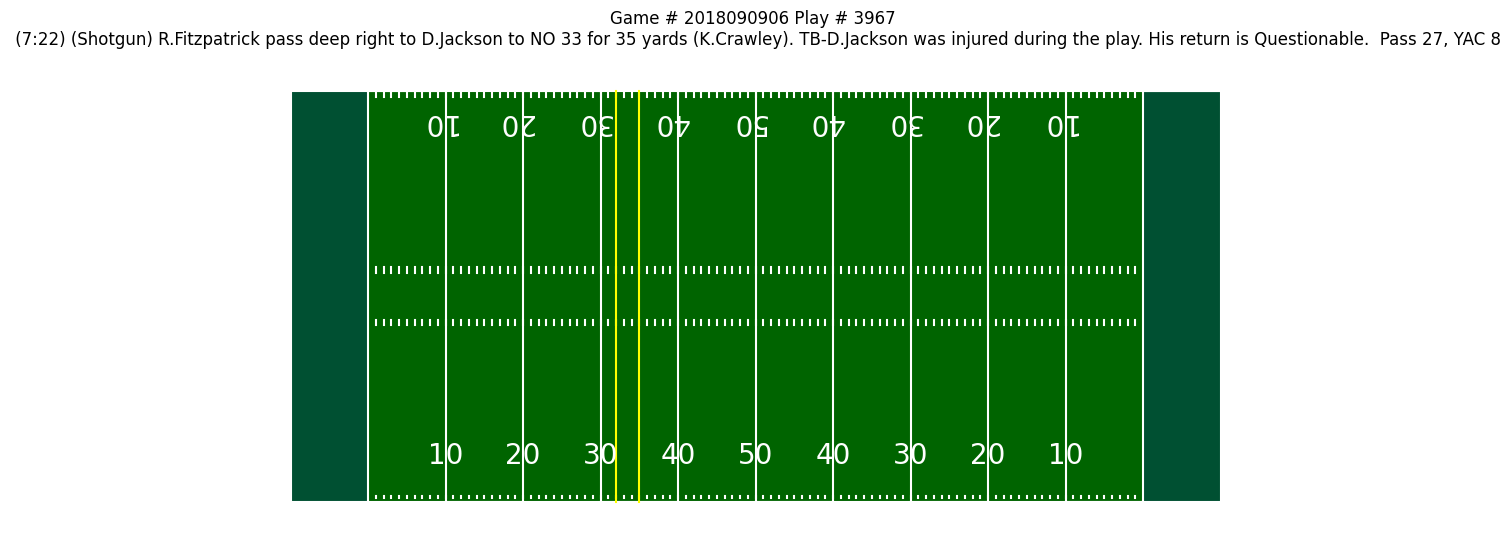

In [90]:
anim = animate_player_movement(1, 3967, 2018090906)

In [91]:
writer = FFMpegWriter(fps=10)
anim.save('animation_notrail.mp4', writer=writer)

In [92]:
import matplotlib
print(matplotlib.get_backend())

inline
